# Exercises & extra-curriculum

See exercises and extra-curriculum in GitHub

In [1]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

RANDOM_SEED = 42

## 1. Make a binary classification dataset w/ Scikit-Learn's `make_moons()` function.

In [17]:
# Create dataset w/ Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

RANDOM_SEED = 42
n_samples = 1000

X, y = make_moons(n_samples, noise=0.07, random_state=RANDOM_SEED)

In [18]:
# Turn data into a DataFrame
import pandas as pd
moons = pd.DataFrame({'X1': X[:, 0],
                      'X2': X[:, 1],
                      'labels': y})
moons.head(10)

,X1,X2,labels
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0
5,0.599064,-0.289773,1
6,0.290090,-0.204688,1
7,-0.038269,0.459429,1
8,1.613771,-0.293970,1
9,0.693337,0.827819,0


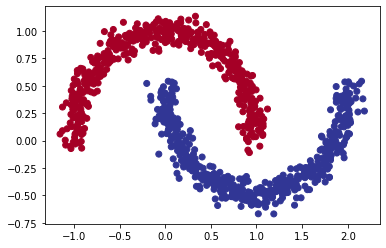

In [19]:
# Visualize data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(x=moons['X1'], y=moons['X2'], c=y, cmap=plt.cm.RdYlBu)

In [5]:
# Turn data into tensors of dtype float
X_moon = torch.from_numpy(X).type(torch.float)
y_moon = torch.from_numpy(y).type(torch.float)

# Split train test
from sklearn.model_selection import train_test_split
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon, y_moon, test_size=0.2, random_state=RANDOM_SEED)
X_moon_train[:5], y_moon_train[:5]

(tensor([[ 1.9469,  0.1784],
         [-0.9174,  0.3979],
         [-0.0786,  0.9969],
         [-0.1162,  0.9932],
         [ 0.3737, -0.2796]]), tensor([1., 0., 0., 0., 1.]))

## 2. Build model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data created in 1.

In [6]:
from torch import nn

class MoonModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


model_5 = MoonModel(input_features=2, output_features=1).to(device)
model_5

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

## 3. Set up binary classification compatible loss function and optimizer to use when training model.

In [7]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_5.parameters(), lr=0.1)

## 4. Create training-testing loop to fit model.

* Forward pass to see what's coming out in the form of logits -> prediction probabilities -> labels.

* To measure model accuracy, create accuracy fn or use accuracy fn in TorchMetrics.

* Train model for long enough for it to reach over 96% accuracy.

* Training loop should output progress every 10 epochs of the model's training and test loss and accuracy

In [8]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct / len(y_pred)) * 100
  return acc

In [9]:
### What's coming out of model?
model_5.eval()

# Logits (raw outputs)
with torch.inference_mode():
  y_logits = model_5(X_moon_test.to(device))[:5]
print(f'Logits: {y_logits}')

# Prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
print(f'Pred probs: {y_pred_probs}')

# Prediction labels
y_preds = torch.round(y_pred_probs).squeeze()
print(f'Pred labels: {y_preds}')

Logits: tensor([[0.0535],
        [0.0556],
        [0.0412],
        [0.0596],
        [0.0262]])
Pred probs: tensor([[0.5134],
        [0.5139],
        [0.5103],
        [0.5149],
        [0.5066]])
Pred labels: tensor([1., 1., 1., 1., 1.])


In [10]:
# Let's calculate accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come w/ torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task='multiclass', num_classes=2).to(device)
acc_fn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 10.1 MB/s eta 0:00:00


MulticlassAccuracy()

In [11]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
                       
epochs = 1000

# Send data to device
X_moon_train, X_moon_test = X_moon_train.to(device), X_moon_test.to(device)
y_moon_train, y_moon_test = y_moon_train.to(device), y_moon_test.to(device)

# Loop thru data
for epoch in range(epochs):
  ### Training
  model_5.train()
  # Forward pass (logits output -> pred probs. -> pred labels)
  y_logits = model_5(X_moon_train).squeeze()
  y_pred_probs = torch.sigmoid(y_logits)
  y_preds = torch.round(y_pred_probs)
  # Shortened: y_preds = torch.round(torch.sigmoid(y_logits))

  # Calc loss and accuracy
  loss = loss_fn(y_logits, y_moon_train) # Loss = compare model raw outputs to desired model outputs
  acc = acc_fn(y_preds, y_moon_train.int()) * 100 # Accuracy fn compares labels

  # Zero gradients
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model_5.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_5(X_moon_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    # Calc test loss and accuracy
    test_loss = loss_fn(test_logits, y_moon_test)
    test_acc = acc_fn(test_preds, y_moon_test.int()) * 100

  # Print what's happening
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%')
  

Epoch: 0 | Loss: 0.7008 | Acc: 50.00% | Test loss: 0.6992 | Test acc: 50.00%
Epoch: 10 | Loss: 0.6961 | Acc: 50.00% | Test loss: 0.6951 | Test acc: 50.00%
Epoch: 20 | Loss: 0.6923 | Acc: 50.00% | Test loss: 0.6918 | Test acc: 50.00%
Epoch: 30 | Loss: 0.6884 | Acc: 61.75% | Test loss: 0.6883 | Test acc: 62.50%
Epoch: 40 | Loss: 0.6832 | Acc: 72.62% | Test loss: 0.6833 | Test acc: 72.00%
Epoch: 50 | Loss: 0.6753 | Acc: 80.25% | Test loss: 0.6757 | Test acc: 80.00%
Epoch: 60 | Loss: 0.6633 | Acc: 84.75% | Test loss: 0.6638 | Test acc: 84.00%
Epoch: 70 | Loss: 0.6455 | Acc: 84.62% | Test loss: 0.6459 | Test acc: 85.00%
Epoch: 80 | Loss: 0.6190 | Acc: 84.62% | Test loss: 0.6198 | Test acc: 85.00%
Epoch: 90 | Loss: 0.5802 | Acc: 84.75% | Test loss: 0.5821 | Test acc: 84.50%
Epoch: 100 | Loss: 0.5265 | Acc: 84.50% | Test loss: 0.5302 | Test acc: 85.00%
Epoch: 110 | Loss: 0.4614 | Acc: 84.62% | Test loss: 0.4680 | Test acc: 85.00%
Epoch: 120 | Loss: 0.3975 | Acc: 85.00% | Test loss: 0.4068 | T

## 5. Make predictions with trained model and plot them using the `plot_decision_boundary` function created in this notebook.

In [34]:
# Plot model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  # Put everything to CPU (works better w/ NumPy + Matplotlib)
  model.to('cpu')
  X, y = X.to('cpu'), y.to('cpu')

  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                       np.linspace(y_min, y_max, 101))
  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  # Make predictions
  model.eval()
  with torch.inference_mode():
    y_logits = model(X_to_pred_on)

  # Test for multi-class or binary and adust logits to prediction labels
  if len(torch.unique(y)) > 2:
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  else:
    y_pred = torch.round(torch.sigmoid(y_logits)) # binary

  # Reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

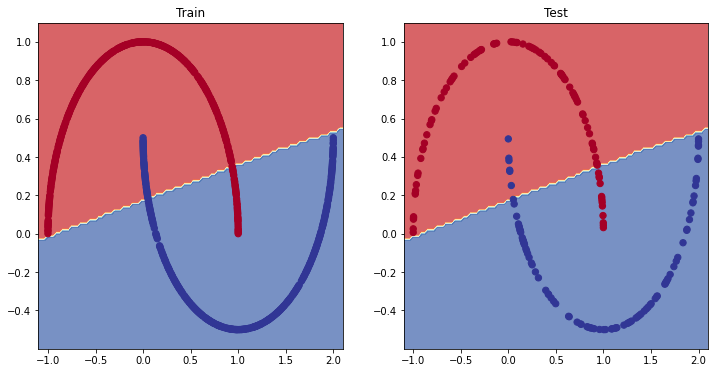

In [13]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_5, X_moon_train, y_moon_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_5, X_moon_test, y_moon_test)

### 6. Replace the Tanh (hyperbolic tangent) activation function in pure PyTorch.

* Feel free to reference ML cheatsheet website for the formula.

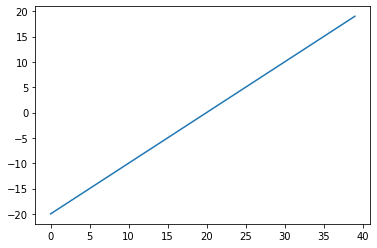

In [14]:
# Create a straight line tensor
line = torch.arange(-20, 20, 1, dtype=torch.float)
plt.plot(line)

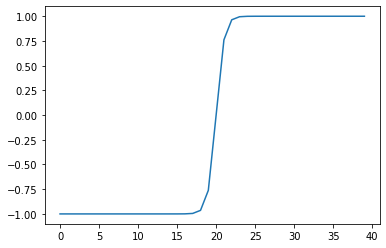

In [15]:
# Test torch.tanh() on the tensor and plot it
plt.plot(torch.tanh(line))

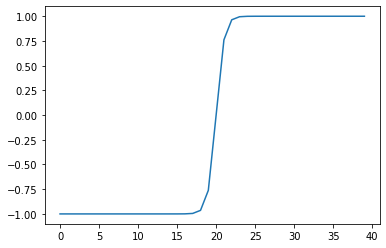

In [16]:
# Replicate torch.tanh() and plot it
def TanH(line):
  result = (torch.exp(line) - torch.exp(line * -1)) / (torch.exp(line) + torch.exp(line * -1))
  return result

plt.plot(TanH(line))

## 7. Create multi-class dataset using spirals data creation function from CS231n.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

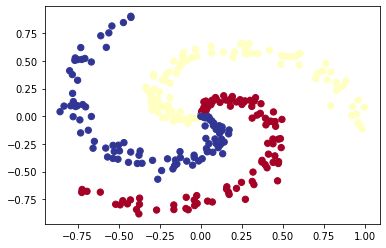

In [25]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N = 100 # num points per class
D = 2 # dimensionality
K = 3 # num classes
X = np.zeros((N*K, D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
  ix = range(N*j, N*(j+1))
  r = np.linspace(0.0, 1, N) # radius
  t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# Visualize data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [26]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [27]:
# Calc accuracy for when fit model
!pip -q install torchmetrics # colab doesn't come w/ this
from torchmetrics import Accuracy

acc_fn = Accuracy(task='multiclass', num_classes=3).to(device)
acc_fn

MulticlassAccuracy()

In [28]:
class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

spiral_model = SpiralModel(input_features=2, output_features=3).to(device)

In [29]:
# Set up data to be device agnostic
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

spiral_model.eval()

# Logits (raw outputs)
with torch.inference_mode():
  y_logits = spiral_model(X_test.to(device))[:5]
print(f'Logits: {y_logits}')

# Prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
print(f'Pred probs: {y_pred_probs}')

# Prediction labels
y_preds = torch.round(y_pred_probs).squeeze()
print(f'Pred labels: {y_preds}')

Logits: tensor([[-0.1731,  0.1386,  0.0238],
        [-0.1655,  0.1601, -0.0070],
        [-0.1752,  0.1424,  0.0192],
        [-0.1734,  0.1376,  0.0253],
        [-0.1730,  0.1398,  0.0222]], device='cuda:0')
Pred probs: tensor([[0.4568, 0.5346, 0.5060],
        [0.4587, 0.5399, 0.4982],
        [0.4563, 0.5355, 0.5048],
        [0.4568, 0.5343, 0.5063],
        [0.4569, 0.5349, 0.5056]], device='cuda:0')
Pred labels: tensor([[0., 1., 1.],
        [0., 1., 0.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.]], device='cuda:0')


In [30]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # Sigmoid activation function built-in
optimizer = torch.optim.Adam(params=spiral_model.parameters(), lr=0.01)

In [32]:
# Build training loop
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
                       
epochs = 1000

# Loop thru data
for epoch in range(epochs):
  ### Training
  spiral_model.train()
  # Forward pass (logits output -> pred probs. -> pred labels)
  y_logits = spiral_model(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # Calc loss and accuracy
  loss = loss_fn(y_logits, y_train) # Loss = compare model raw outputs to desired model outputs
  acc = acc_fn(y_pred, y_train) * 100 # Accuracy fn compares labels

  # Zero gradients
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  spiral_model.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = spiral_model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # Calc test loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_preds, y_test) * 100

  # Print what's happening
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.2f} | Acc: {acc:.2f}% | Test loss: {test_loss:.2f} | Test acc: {test_acc:.2f}%')
  

Epoch: 0 | Loss: 1.11 | Acc: 35.00% | Test loss: 1.12 | Test acc: 26.67%
Epoch: 100 | Loss: 0.47 | Acc: 80.00% | Test loss: 0.42 | Test acc: 80.00%
Epoch: 200 | Loss: 0.08 | Acc: 99.17% | Test loss: 0.04 | Test acc: 100.00%
Epoch: 300 | Loss: 0.03 | Acc: 99.17% | Test loss: 0.00 | Test acc: 100.00%
Epoch: 400 | Loss: 0.02 | Acc: 99.17% | Test loss: 0.00 | Test acc: 100.00%
Epoch: 500 | Loss: 0.02 | Acc: 99.17% | Test loss: 0.00 | Test acc: 100.00%
Epoch: 600 | Loss: 0.01 | Acc: 99.17% | Test loss: 0.00 | Test acc: 100.00%
Epoch: 700 | Loss: 0.01 | Acc: 99.17% | Test loss: 0.00 | Test acc: 100.00%
Epoch: 800 | Loss: 0.01 | Acc: 99.17% | Test loss: 0.00 | Test acc: 100.00%
Epoch: 900 | Loss: 0.01 | Acc: 99.17% | Test loss: 0.00 | Test acc: 100.00%


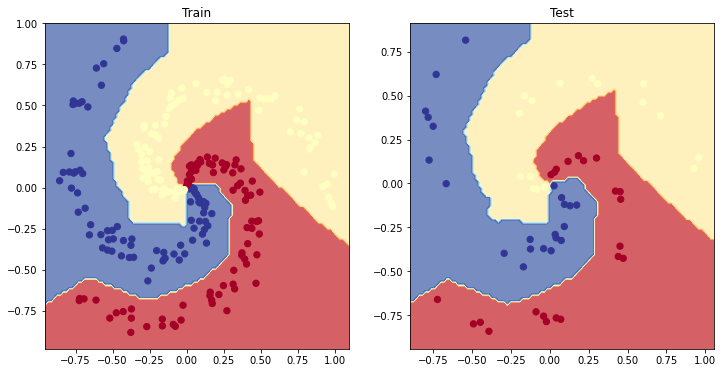

In [36]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(spiral_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(spiral_model, X_test, y_test)